<a href="https://colab.research.google.com/github/mrbundles-GIT/WQU/blob/main/GARCH_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ReadMe: 


I am using this notebook as a quick reference and a jump off point for ideas related to GARCH. I will be branching this off to a new version wherethe stock data will come from a free public souce such as Google Finance.



In the previous lesson, we learned how to get data from an API. In this lesson, we have two goals. First, we'll take the code we used to access the API and build an AlphaVantageAPI class. This will allow us to reuse our code. Second, we'll create a SQLRepository class that will help us load our stock data into a SQLite database and then extract it for later use. Additionally, we'll build this code using a technique called test driven development, where we'll use assert statements to make sure everything is working properly. That way, we'll avoid issues later when we build our application.

In [ ]:
#@title Import Libraries { run: "auto" }

import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import numpy as np
import pandas as pd
import gspread as gs
from glob import glob
import json

from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Define Functions { run: "auto", display-mode: "form" }

def make_ticker_from_csv(ticker):
  
  # Identify the filepath
  filepath= f"/content/drive/MyDrive/Public Data Projects/ticker_data/{ticker}.csv"
  df = pd.read_csv(filepath)
  df.set_index('date', inplace=True)
  df.index=pd.to_datetime(df.index)
  return df

def make_ticker_from_google(ticker, years=5):
  # What Date is ist today? Identidy Year Month Day
  
  now = datetime.now()
  year = now.strftime("%Y")
  month = now.strftime("%m")
  day = now.strftime("%d")

  #Import ticker data from Google Sheets
  worksheet = gc.open("Stocks").sheet1
  worksheet.update_cell(1,11,ticker)
  worksheet.update_cell(2,11,year)
  worksheet.update_cell(3,11,month)
  worksheet.update_cell(4,11,day)
  worksheet.update_cell(5,11,years)

  # G Worksheet needs a few seconds to generate the data
  time.sleep(12)

  # Get all rows
  rows = worksheet.get_all_values()

  # Convert to a DataFrame and render.

  df= pd.DataFrame.from_records(rows)
  df = df[[0,1,2,3,4,5]]
  df= df.rename(columns=df.iloc[0]).drop(df.index[0])
  df.set_index('date', inplace=True)
  df.index=pd.to_datetime(df.index)
  df=df[df.columns.tolist()].astype(float)

  csv_filepath= f"/content/drive/MyDrive/Public Data Projects/ticker_data/{ticker}.csv"
  df.to_csv(csv_filepath)

  return df

  pass

def make_ticker(ticker, years=5):

  # Identify the filepath
  filepath= f"/content/drive/MyDrive/Public Data Projects/ticker_data/{ticker}.csv"

  # Check whether a path pointing to a file
  if os.path.isfile(filepath): df = make_ticker_from_csv(ticker)
  else: df= make_ticker_from_google(ticker, years)

  if pd.to_datetime(max(df.index)) == pd.to_datetime(datetime.now()): pass
  else: df= make_ticker_from_google(ticker, years)
  return df


In [ ]:
#@title Make Ticker Stock Sheet { form-width: "30%", display-mode: "form" }
ticker="AAPL" #@param ["GOOG", "AAPL", "TSLA", "BTC", "SUZLON"] {allow-input: true}
years= "5" #@param [5,10,20 ] {allow-input: true}

make_ticker_from_google(ticker, years)

# Does  return a DataFrame?
assert isinstance(df, pd.DataFrame)

# Does DataFrame have 5 columns?
assert df.shape[1]==5

# Does DataFrame have a DatetimeIndex?
assert isinstance(df.index, pd.DatetimeIndex)

# Is the index name "date"?
assert df.index.name == "date"
assert all(df.columns == ['open', 'high', 'low', 'close', 'volume'])
assert all(df.dtypes==float)

fig, ax = plt.subplots(figsize=(15, 6))
# Plot `df closing price
df["high"].plot(ax=ax, label= ticker)
df["low"].plot(ax=ax, label= ticker)

# Label axes
plt.xlabel("Date")
plt.ylabel("Closing Price")

# Add legend
plt.legend
print(df.head(10))
print(ticker)
print()

In [ ]:


DFGOOG

,open,high,low,close,volume
date,,,,,
2022-11-23,97.34,99.07,97.34,98.82,17568859.0
2022-11-22,96.16,97.55,94.41,97.33,18868850.0
2022-11-21,97.56,98.72,95.67,95.83,18696874.0
2022-11-18,99.01,99.16,96.74,97.80,24969880.0
2022-11-17,97.18,99.48,97.10,98.50,21818732.0
...,...,...,...,...,...
2017-11-30,51.12,51.42,50.75,51.07,1724031.0
2017-11-29,52.13,52.20,50.78,51.08,2459426.0
2017-11-28,52.75,53.12,52.00,52.37,1424394.0


<function matplotlib.pyplot.legend(*args, **kwargs)>

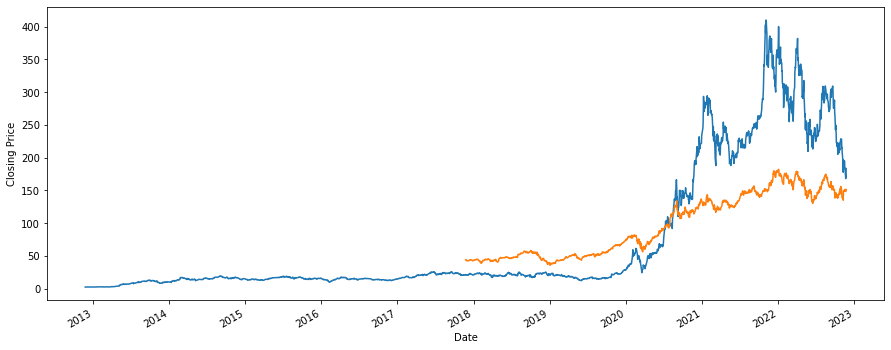

In [ ]:
#@title Compare Volatility
ticker_1 = "TSLA" #@param ["TSLA", "AAPL"] {allow-input: true}
ticker_2 = "AAPL" #@param ["TSLA", "AAPL"] {allow-input: true}

dfTSLA=make_ticker_from_csv("TSLA")
dfAAPL=make_ticker_from_csv("AAPL")

fig, ax = plt.subplots(figsize=(15, 6))
# Plot `df closing price
dfTSLA["close"].plot(ax=ax, label= ticker_1)
dfAAPL["close"].plot(ax=ax, label= ticker_2, color="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Closing Price")

# Add legend
plt.legend

<function matplotlib.pyplot.legend(*args, **kwargs)>

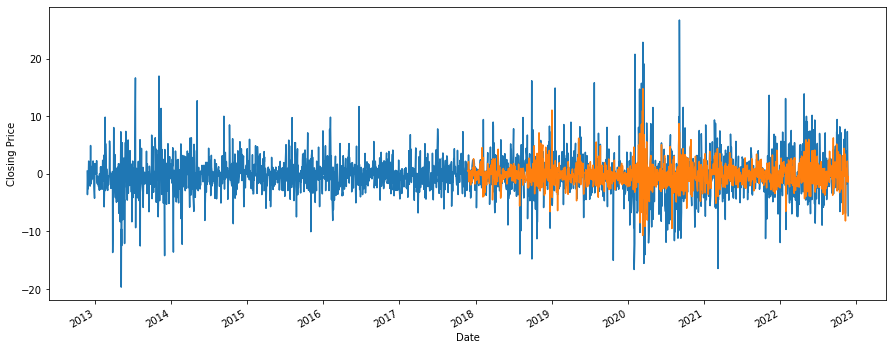

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
# Plot `df closing price
(dfTSLA["close"].pct_change()*100).plot(ax=ax, label= ticker_1)
(dfAAPL["close"].pct_change()*100).plot(ax=ax, label= ticker_2, color="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Closing Price")

# Add legend
plt.legend

In [ ]:
ticker="BABA"
filepath= f"/content/drive/MyDrive/Public Data Projects/ticker_data/{ticker}.csv"
df = pd.read_csv(filepath)
df


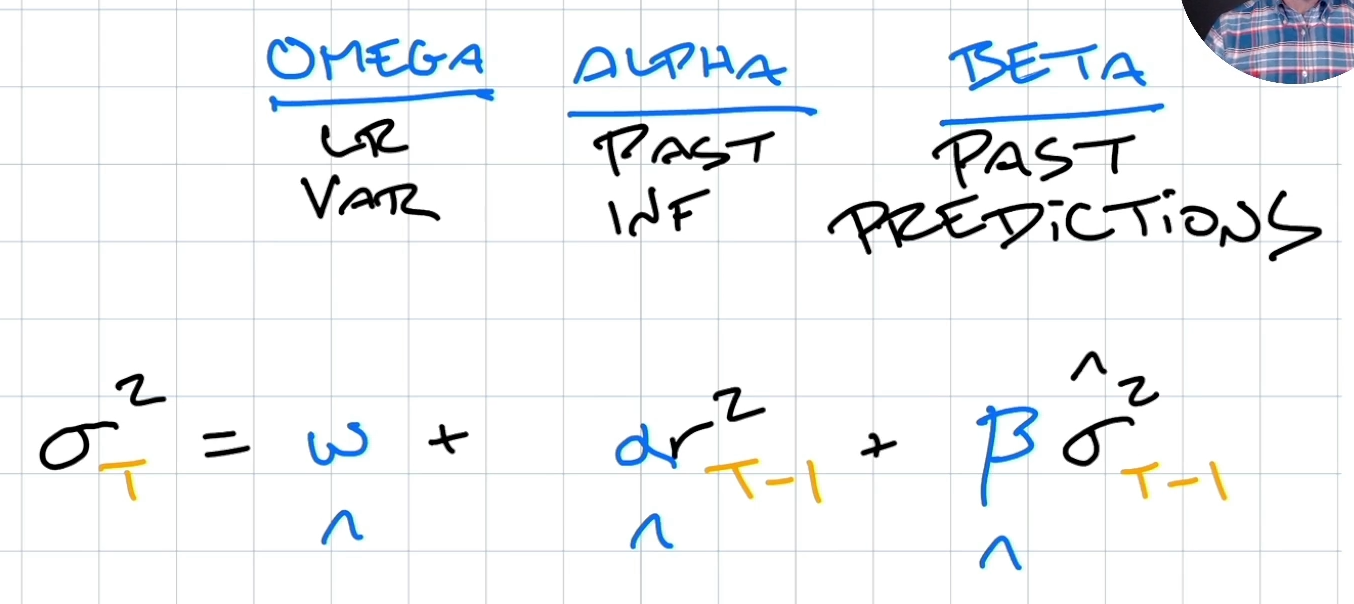

In [ ]:
"""
sum of alpha and beta is less than 1

"""

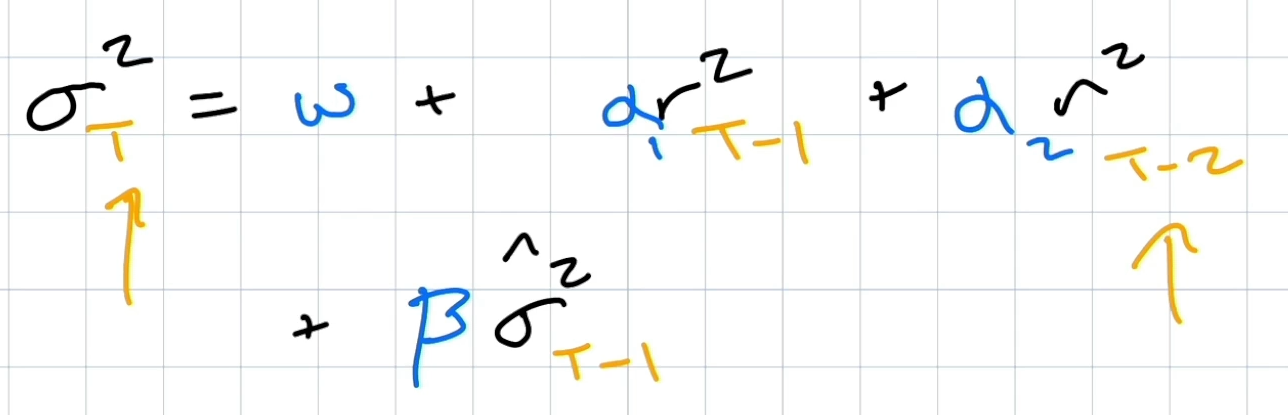

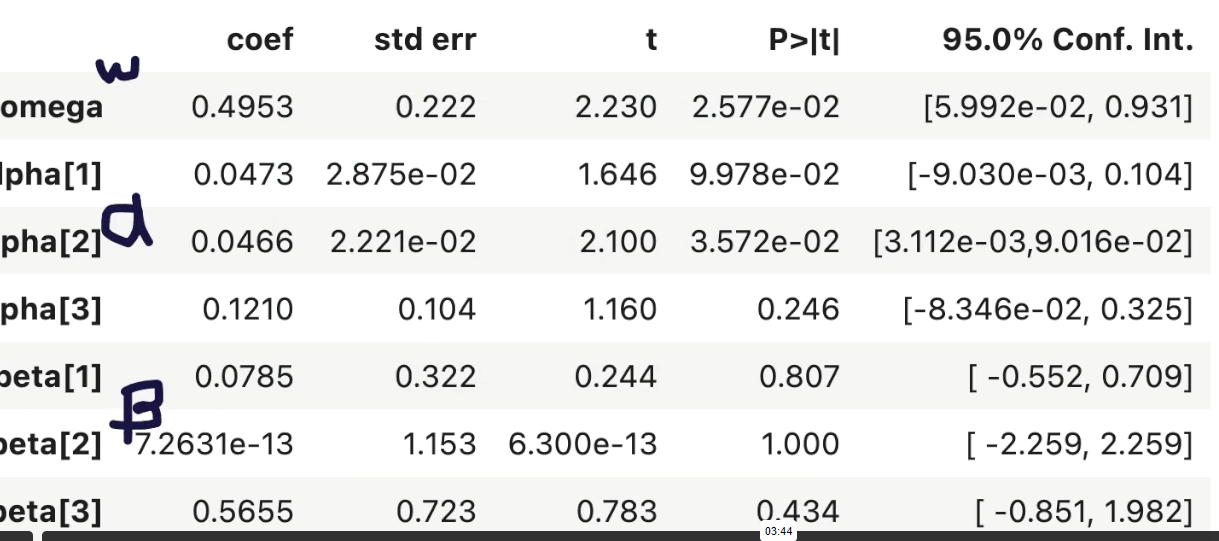

P>|t| refers to statistical significance and should be lover than 0.05

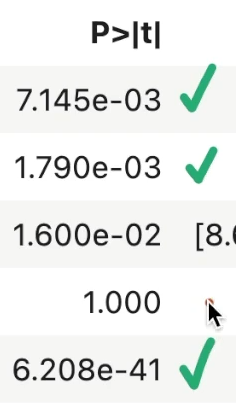

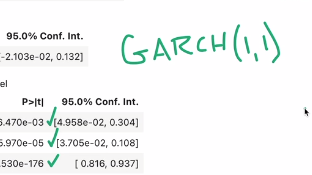

In [ ]:
from model import GarchModel

# Instantiate a `GarchModel`
gm_ambuja = GarchModel(ticker="AMBUJACEM.BSE", repo=repo, use_new_data=False)

# Does `gm_ambuja` have the correct attributes?
assert gm_ambuja.ticker == "AMBUJACEM.BSE"
assert gm_ambuja.repo == repo
assert not gm_ambuja.use_new_data
assert gm_ambuja.model_directory == settings.model_directory

In [ ]:
    def __init__(self, ticker, repo, use_new_data):
    
        self.ticker = ticker
        self.repo = repo
        self.use_new_data = use_new_data
        self.model_directory = settings.model_directory


In [ ]:
    def wrangle_data(self, n_observations):

        """Extract data from database (or get from AlphaVantage), transform it
        for training model, and attach it to `self.data`.

        Parameters
        ----------
        n_observations : int
            Number of observations to retrieve from database

        Returns
        -------
        None
        """
        # Add new data to database if required
        if self.use_new_data:
          #Instantiate an API class
          api= AlphaVantageAPI()
          #Get Data
          new_data=api.get_daily(ticker=self.ticker)
          # Insert data into repo
          self.repo.insert_table(
              table_name=self.ticker, records=new_data, if_exists="replace"
          )

        # Pull data from SQL database
        df = self.repo.read_table(table_name=self.ticker, limit=n_observations+1)

        # Clean data, attach to class as `data` attribute
        df.sort_index(ascending=True, inplace=True)
        df["return"] = df["close"].pct_change()*100
        
        self.data = df["return"].dropna()

In [ ]:

    def fit(self, p, q) :

        """Create model, fit to `self.data`, and attach to `self.model` attribute.
        For assignment, also assigns adds metrics to `self.aic` and `self.bic`.

        Parameters
        ----------
        p : int
            Lag order of the symmetric innovation

        q : ind
            Lag order of lagged volatility

        Returns
        -------
        None
        """
        # Train Model, attach to `self.model`
        self.model = arch_model(self.data, p=p, q=q, rescale=False).fit(disp=0)

In [ ]:
    def __clean_prediction(self, prediction):

        """Reformat model prediction to JSON.

        Parameters
        ----------
        prediction : pd.DataFrame
            Variance from a `ARCHModelForecast`

        Returns
        -------
        dict
            Forecast of volatility. Each key is date in ISO 8601 format.
            Each value is predicted volatility.
        """
        # Calculate forecast start date
        start= prediction.index[0] + pd.DateOffset(days=1)

        # Create date range
        prediction_dates= pd.bdate_range(start=start, periods=prediction.shape[1])

        # Create prediction index labels, ISO 8601 format
        prediction_index= [d.isoformat() for d in prediction_dates]

        # Extract predictions from DataFrame, get square root
        data= prediction.values.flatten()**0.5

        # Combine `data` and `prediction_index` into Series
        prediction_formatted= pd.Series(data, index=prediction_index)

        # Return Series as dictionary
        return prediction_formatted.to_dict()
        

In [ ]:
    def predict_volatility(self, horizon):

        """Predict volatility using `self.model`

        Parameters
        ----------
        horizon : int
            Horizon of forecast, by default 5.

        Returns
        -------
        dict
            Forecast of volatility. Each key is date in ISO 8601 format.
            Each value is predicted volatility.
        """
        # Generate variance forecast from `self.model`
        prediction = self.model.forecast(horizon=horizon, reindex=False).variance

        # Format prediction with `self.__clean_predction`
        prediction_formatted = self.__clean_prediction(prediction)

        # Return `prediction_formatted`
        return prediction_formatted


In [ ]:
    def dump(self):

        """Save model to `self.model_directory` with timestamp.

        Returns
        -------
        str
            filepath where model was saved.
        """
        # Create timestamp in ISO format
        timestamp = pd.Timestamp.now().isoformat()
        # Create filepath, including `self.model_directory`
        filepath = os.path.join(self.model_directory, f"{timestamp}_{self.ticker}.pkl")
        # Save `self.model`
        joblib.dump(self.model, filepath)

        # Return filepath
        return filepath

    def load(self):

        """Load most recent model in `self.model_directory` for `self.ticker`,
        attach to `self.model` attribute.

        """
        # Create pattern for glob search
        pattern = os.path.join(self.model_directory, f"*{self.ticker}.pkl")

        # Use glob to get most recent model, handle errors
        try:
          model_path= sorted(glob(pattern))[-1]
          #Handle possible IndexError
        except IndexError:
          raise Exception(f"No model trained for '{ticker}'.")
        
        # Load model and attach to `self.model`
        self.model = joblib.load(model_path)


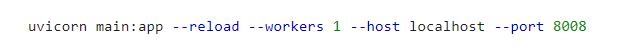